***1) Set Strategy Parameters***

In [3]:
# Set Strategy Parameters
initial_capital = 10000
# Universe
universe_assets = ['XBT']
quote_currencies = ['USD']
wt_threshold = .6 # Allocation to Bitcoin when ema cross buy signal
interval_ripple = '15m'
interval_wave = '1h'
interval_tide = '6h'
start = '2020-10-01'
# Technical
fast_period = 9 # Fast Ripple Exponential Moving Average Lookback Period
slow_period = 21 # Slow Ripple Exponential Moving Average Lookback Period
RSIPERIOD = 14 #
RSIHigh = 70 #

***2) Import Dependencies***

In [4]:
# Initial Imports
import pandas as pd
import numpy as np
import math
import shrimpy
from pathlib import Path
from dotenv import load_dotenv
import time
from joblib import dump,load # Save Models
from numpy import random
import os
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
from datetime import timedelta
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

***3) Set Environment Variables***

In [5]:
# Set environment variables from the .env file
env_path = Path("/Users/gdepa")/'.env'
load_dotenv(env_path)
shrimpy_public_key = os.getenv("SHRIMPY_DEV_PUBLIC")
shrimpy_private_key = os.getenv("SHRIMPY_DEV_SECRET")
shrimpy_client = shrimpy.ShrimpyApiClient(shrimpy_public_key, shrimpy_private_key)   
users = shrimpy_client.list_users()
shrimpy_user_id = users[1]['id'] # first id in list of users

***4) Define Fetch Data Functions***

In [6]:

# Get and organize closing prices into dataframe from list of trading pairs from one exchange from shrimpy rest api
def calc_trading_pairs_df(exchange):
    exchange_pairs = shrimpy_client.get_trading_pairs(exchange)
    exchange_pairs_df = pd.DataFrame(columns=['base','quote'])
    for key, value in enumerate(exchange_pairs):
        exchange_pairs_df.loc[key] = [value['baseTradingSymbol'],value['quoteTradingSymbol']]
    return exchange_pairs_df

def universe_selection(exchange,universe_assets, quote_currencies):
    trading_pairs_df = calc_trading_pairs_df(exchange)
    universe_pairs_df = trading_pairs_df[(trading_pairs_df['base'].isin(universe_assets) & trading_pairs_df['quote'].isin(quote_currencies))]
    return universe_pairs_df

def get_universe_data(exchange, universe_assets, quote_currencies, interval, start):
    universe_pairs_df = universe_selection(exchange,universe_assets,quote_currencies)
    universe_prices_df = pd.DataFrame()
    universe_volume_df = pd.DataFrame()
    for index, row in universe_pairs_df.iterrows():
        candles = shrimpy_client.get_candles(exchange, row['base'], row['quote'], interval, start)
        time = []
        prices = []
        quotevolume = []
        for key, value in enumerate(candles):
            time.append(value['time'])
            prices.append(value['close'])
            quotevolume.append(value['quoteVolume'])
        prices_df = pd.DataFrame(list(zip(time, prices)), columns = ['time', row['base'] + "_" + row['quote']])
        volume_df = pd.DataFrame(list(zip(time,quotevolume)),columns=['time',row['base']+"_"+row['quote']])
        prices_df['time'] = pd.to_datetime(prices_df['time'])
        volume_df['time'] = pd.to_datetime(volume_df['time'])
        if universe_prices_df.empty:
            universe_prices_df = prices_df
        else:
            universe_prices_df = pd.merge(universe_prices_df, prices_df, left_on='time', right_on = 'time', how = 'left')
        if universe_volume_df.empty:
            universe_volume_df = volume_df
        else:
            universe_volume_df = pd.merge(universe_volume_df, volume_df, left_on='time',right_on='time', how='left')
    universe_prices_df.set_index('time',inplace=True)
    universe_volume_df.set_index('time',inplace=True)
    return universe_prices_df, universe_volume_df


def calc_bare_returns(prices_df, start_date_str, numDays, list_of_momentums):
    bare_returns = pd.DataFrame()
    prices_df.index = pd.to_datetime(prices_df.index,utc=True)
    #for single_date in (datetime.datetime.strptime(start_date_str, "%Y-%m-%d") +datetime.timedelta(days=n) for n in range(numDays)):
    #df_temp = prices_df.loc[str(single_date.date())]

    df_temp = prices_df.astype(float)
    forecast=1
    data = df_temp.pct_change(forecast)
    data = data.shift(-1)
    data = pd.DataFrame(data.unstack())
    name = "F_"+str(forecast)+"_15m_bare_returns"
    data.rename(columns={0:name},inplace=True)
    data.reset_index(inplace=True)

    for i in list_of_momentums:
        feature = df_temp.pct_change(i)
        feature = pd.DataFrame(feature.unstack())
        name = str(i)+"_15m_bare_returns"
        feature.rename(columns={0:name},inplace=True)
        feature.reset_index(inplace=True)
        data = pd.merge(data,feature,left_on=['level_0','time'], right_on=['level_0','time'], how='left', suffixes=('_original', 'right'))
    data.dropna(axis=0,how='any',inplace=True)
    bare_returns = pd.concat([bare_returns,data])
    return bare_returns

def calc_Zscore(volume_df, start_date_str, numDays, window=5):
    def zscore_func(x):
        return(x[-1] - x[:-1].mean())/x[:-1].std(ddof=0)
    total_vol_z_score = pd.DataFrame()
    df_temp = volume_df
    df_temp = df_temp.rolling(window=window).apply(zscore_func)
    df_temp.dropna(axis=0,how='any',inplace=True)
    total_vol_z_score = pd.concat([total_vol_z_score,df_temp])
    total_vol_z_score = pd.DataFrame(total_vol_z_score.unstack())
    name = str(window)+"_15m_vol_z_score"
    total_vol_z_score.rename(columns={0: name}, inplace = True)
    total_vol_z_score.reset_index(inplace = True)
    return total_vol_z_score

***Define Backtest Function***

In [9]:
def btc_usd_kraken_backtest(initial_capital, wt_threshold,universe_assets, quote_currencies, interval_ripple, interval_wave,interval_tide,start,fast_period,slow_period):
    #df_balances_kraken, df_balances_kucoin, df_balances_coinbasepro = get_balances(shrimpy_user_id, kraken_id, kucoin_id, coinbasepro_id)
    df_universe_prices_ripple,df_universe_volume_ripple = get_universe_data('kraken',universe_assets, quote_currencies,interval_ripple,start)
    df_universe_prices_wave,df_universe_volume_wave = get_universe_data('kraken',universe_assets, quote_currencies,interval_wave,start)
    df_universe_prices_tide,df_universe_volume_tide = get_universe_data('kraken',universe_assets, quote_currencies,interval_tide,start)

    df_universe_prices_ripple['XBT_USD'] = df_universe_prices_ripple['XBT_USD'].astype(float)
    df_universe_prices_wave['XBT_USD'] = df_universe_prices_wave['XBT_USD'].astype(float)
    df_universe_prices_tide['XBT_USD'] = df_universe_prices_tide['XBT_USD'].astype(float)

    df_universe_prices_ripple['return'] = df_universe_prices_ripple['XBT_USD'].pct_change()
    df_universe_prices_wave['return'] = df_universe_prices_wave['XBT_USD'].pct_change()
    df_universe_prices_tide['return'] = df_universe_prices_tide['XBT_USD'].pct_change()

    df_universe_prices_ripple['ema_fast'] = df_universe_prices_ripple['XBT_USD'].ewm(halflife=fast_period).mean()
    df_universe_prices_ripple['ema_slow'] = df_universe_prices_ripple['XBT_USD'].ewm(halflife=slow_period).mean()
    df_universe_prices_ripple['crossover_long'] = np.where(df_universe_prices_ripple['ema_fast'] > df_universe_prices_ripple['ema_slow'],1.0,0.0)
    df_universe_prices_ripple['crossover_short'] = np.where(df_universe_prices_ripple['ema_fast'] < df_universe_prices_ripple['ema_slow'],-1.0,0.0)
    df_universe_prices_ripple['crossover_signal'] = df_universe_prices_ripple['crossover_long'] + df_universe_prices_ripple['crossover_short']
    df_universe_prices_ripple[['XBT_USD','ema_fast','ema_slow']].plot(figsize=[7,7])
    
    signal_df = df_universe_prices_ripple.loc[:,['XBT_USD','crossover_signal', 'return']]

    signal_df['btc_wt'] = np.where(signal_df['crossover_signal'] == 1.0, wt_threshold, 1-wt_threshold)
    signal_df['usd_wt'] = 1-signal_df['btc_wt']
    # Action Happens one candle after signal is generated
    signal_df['btc_wt'] = signal_df['btc_wt'].shift(1)
    signal_df['usd_wt'] = signal_df['usd_wt'].shift(1)
    signal_df['XBT_USD_prev'] = signal_df['XBT_USD'].shift(1)

    usd_balance = []
    btc_balance = []
    btc_total = []
    usd_total = []
    cost_basis = []
    for index, row in signal_df.iterrows():
        if len(usd_balance) ==0:
            total_btc = 0
            total_usd = initial_capital
            balance_usd = total_usd
            balance_btc = balance_usd/row['XBT_USD']
            btc_total.append(total_btc)
            usd_total.append(total_usd)
            usd_balance.append(balance_usd)
            btc_balance.append(balance_btc)
        else:
            total_btc = (row['btc_wt']*usd_balance[-1])/ row['XBT_USD_prev']
            total_usd = row['usd_wt']*usd_balance[-1]
            balance_usd = (total_btc * row['XBT_USD']) + total_usd
            balance_btc = balance_usd/row['XBT_USD']
            btc_total.append(total_btc)
            usd_total.append(total_usd)
            usd_balance.append(balance_usd)
            btc_balance.append(balance_btc)

    signal_df['usd_balance'] = usd_balance
    signal_df['btc_balance'] = btc_balance
    signal_df['btc_total'] = btc_total
    signal_df['usd_total'] = usd_total

    signal_df['usd_change'] = signal_df['usd_balance'].pct_change()
    signal_df['btc_change'] = signal_df['btc_balance'].pct_change()
    signal_df['cum_returns_usd'] = (1+signal_df['usd_change']).cumprod()
    signal_df['cum_returns_btc'] = (1+signal_df['btc_change']).cumprod()
    signal_df['cum_returns_btcusd'] = (1+signal_df['return']).cumprod()
    
    USD_accumulation_rate = (signal_df['cum_returns_usd'][-1]) - 1
    USD_accumulation = USD_accumulation_rate * initial_capital
    BTC_accumulation_rate =  (signal_df['cum_returns_btc'][-1]-1)
    BTC_accumulation = BTC_accumulation_rate * signal_df['btc_balance'][0]
    btcusd_return_rate = (signal_df['cum_returns_btcusd'][-1]) -1
    btcusd_returns = btcusd_return_rate * initial_capital
    
    
    print(f"--------------- BackTest Info -------------------------")
    print(f"Initial Capital = {initial_capital} USD, {signal_df['btc_balance'][0]}")
    print(f"Interval = {interval_ripple}")
    print(f"wt_threshold = {wt_threshold}")
    print(f"----------- Performance Stats --------------------------")
    print(f"Capital at End of Period = {signal_df['usd_balance'][-1]} USD, {signal_df['btc_balance'][-1]}")
    print(f"USD Accumulation = {USD_accumulation} USD, {USD_accumulation_rate *100} % ")
    print(f"BTC Accumulation = {BTC_accumulation} BTC, {BTC_accumulation_rate*100} %")
    print(f"Benchmarks")
    print(f"    btcusd returns = {btcusd_returns} USD, {btcusd_return_rate} BTC")
    # Plot Cum_returns
    signal_df[['cum_returns_usd', 'cum_returns_btc', 'cum_returns_btcusd']].plot(figsize=[7,7])
    # Plot Returns
    #signal_df[['usd_change', 'btc_change']].plot(figsize=[7,7])

***Run Backtest***

--------------- BackTest Info -------------------------
Initial Capital = 10000 USD, 0.5185699913917382
Interval = 15m
wt_threshold = 0.6
----------- Performance Stats --------------------------
Capital at End of Period = 9925.65502059408 USD, 0.51873896063562
USD Accumulation = -74.34497940593477 USD, -0.7434497940593476 % 
BTC Accumulation = 0.00016896924388146048 BTC, 0.03258369105161307 %
Benchmarks
    btcusd returns = -77.57807071221757 USD, -0.007757807071221756 BTC


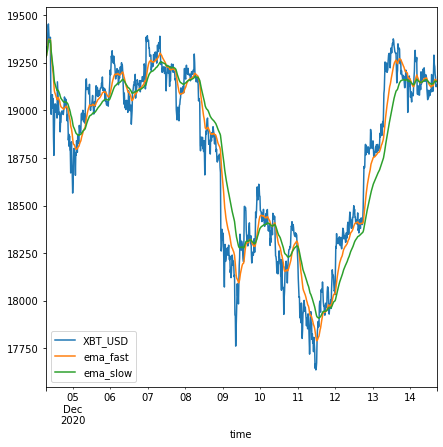

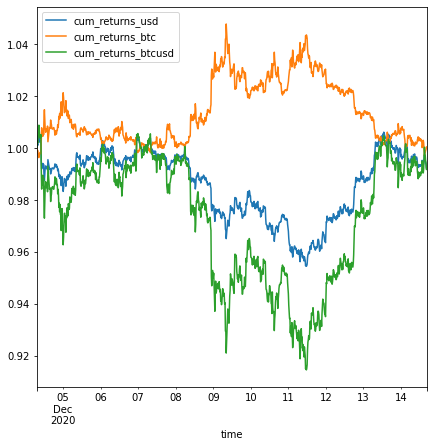

In [10]:
btc_usd_kraken_backtest(initial_capital, wt_threshold,universe_assets, quote_currencies, interval_ripple, interval_wave,interval_tide,start,fast_period,slow_period)